### Version History
* 020223 First release with 6Time Series as input

In [1]:
# Libraries
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt

In [2]:
# mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### PG Data

In [97]:
# Read in KO train and test set
df_PG_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/PG_MODEL_Train.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_PG_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/PG_MODEL_Test.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_PG_train.head()

,Unnamed: 0,PG_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2000-01-03,0,52.93,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,1,51.91,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,2,50.83,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,3,53.21,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,4,57.53,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [98]:
df_PG_test.head()

,Unnamed: 0,PG_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2016-01-04,0,78.37,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,18425.306,94.620003,1.73,0.0,5.1
2016-01-05,1,78.62,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,18425.306,91.635144,1.73,0.0,4.8
2016-01-06,2,77.86,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,18425.306,95.459999,1.74,0.0,4.9
2016-01-07,3,77.18,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,18425.306,95.650002,1.75,0.0,4.8
2016-01-08,4,75.97,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,18425.306,95.709999,1.77,0.0,4.9


#### Prepare PG Training and Testing Data

In [106]:
df_PG_train.columns

Index(['Unnamed: 0', 'PG_Close', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr', 'PCE', 'GDP', 'DXY_Close', 'CRE', 'CPI',
       'UNRATE'],
      dtype='object')

In [107]:
df_PG_train.drop('Unnamed: 0', axis=1, inplace=True)
df_PG_test.drop('Unnamed: 0', axis=1, inplace=True)
df_PG_train.head()

,PG_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,52.93,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,51.91,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,50.83,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,53.21,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,57.53,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [108]:
# rename the price column, "Price" will be used as target for model training
df_PG_train.rename(columns={"PG_Close": "Price"}, inplace=True)
df_PG_test.rename(columns={"PG_Close": "Price"}, inplace=True)
df_PG_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,52.93,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,51.91,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,50.83,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,53.21,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,57.53,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [109]:
# MUST set this variable for correct data model input

PG_EXTRA_FEATURES = len(df_PG_train.columns) - 1
PG_EXTRA_FEATURES # 14

14

#### Prepare Time Series Window

In [110]:
# Setup WINDOW_SIZE and HORIZON
HORIZON = 1                      # HORIZON = 1 daily price prediction
WINDOW_SIZE = 7                  # WINDOW_SIZE = 7  based on previous 7-day historical data

In [111]:
# Add windowed columns in training data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_PG_train[f"Price+{i+1}"] = df_PG_train["Price"].shift(periods=i+1)
df_PG_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,52.93,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,...,1.16,0.3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,51.91,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,...,1.16,0.3,3.8,52.93,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,50.83,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,...,1.18,0.3,4.0,51.91,52.93,NaN,NaN,NaN,NaN,NaN
2000-01-06,53.21,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,...,1.18,0.3,4.0,50.83,51.91,52.93,NaN,NaN,NaN,NaN
2000-01-07,57.53,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,...,1.20,0.3,4.0,53.21,50.83,51.91,52.93,NaN,NaN,NaN


In [112]:
# Add windowed columns for test data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_PG_test[f"Price+{i+1}"] = df_PG_test["Price"].shift(periods=i+1)
df_PG_test.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,78.37,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,...,1.73,0.0,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,78.62,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,...,1.73,0.0,4.8,78.37,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,77.86,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,...,1.74,0.0,4.9,78.62,78.37,NaN,NaN,NaN,NaN,NaN
2016-01-07,77.18,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,...,1.75,0.0,4.8,77.86,78.62,78.37,NaN,NaN,NaN,NaN
2016-01-08,75.97,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,...,1.77,0.0,4.9,77.18,77.86,78.62,78.37,NaN,NaN,NaN


#### Prepare X,y

In [113]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 

# X_train and y_train preparation
X_PG_train = df_PG_train.dropna().drop("Price", axis=1).astype(np.float32)
y_PG_train = df_PG_train.dropna()["Price"].astype(np.float32)
X_PG_train.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-12,5.70,6.16,6.49,6.53,6.63,6.76,6.72,6.97,6952.200195,10002.178711,...,1.16,0.3,3.9,58.150002,57.250000,57.529999,53.209999,50.830002,51.910000,52.930000
2000-01-13,5.66,6.10,6.40,6.45,6.54,6.67,6.63,6.88,6952.200195,10002.178711,...,1.18,0.3,3.9,57.779999,58.150002,57.250000,57.529999,53.209999,50.830002,51.910000
2000-01-14,5.69,6.13,6.44,6.49,6.59,6.71,6.69,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,56.790001,57.779999,58.150002,57.250000,57.529999,53.209999,50.830002
2000-01-18,5.79,6.15,6.47,6.53,6.65,6.78,6.75,6.94,6952.200195,10002.178711,...,1.19,0.3,3.9,57.779999,56.790001,57.779999,58.150002,57.250000,57.529999,53.209999
2000-01-19,5.78,6.12,6.46,6.51,6.62,6.75,6.73,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,57.750000,57.779999,56.790001,57.779999,58.150002,57.250000,57.529999


In [114]:
y_PG_train.head()

Date
2000-01-12    57.779999
2000-01-13    56.790001
2000-01-14    57.779999
2000-01-18    57.750000
2000-01-19    56.980000
Name: Price, dtype: float32

In [115]:
# X_test and y_test preparation
X_PG_test = df_PG_test.dropna().drop("Price", axis=1).astype(np.float32) 
y_PG_test = df_PG_test.dropna()["Price"].astype(np.float32)
X_PG_test.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-13,0.46,0.60,0.91,1.15,1.51,1.85,2.08,2.47,12962.900391,18425.306641,...,1.80,0.0,4.7,76.510002,76.669998,75.970001,77.180000,77.860001,78.620003,78.370003
2016-01-14,0.43,0.55,0.90,1.14,1.52,1.87,2.10,2.51,12962.900391,18425.306641,...,1.84,0.0,4.7,75.849998,76.510002,76.669998,75.970001,77.180000,77.860001,78.620003
2016-01-15,0.37,0.49,0.85,1.08,1.46,1.79,2.03,2.44,12962.900391,18425.306641,...,1.89,0.0,4.7,76.150002,75.849998,76.510002,76.669998,75.970001,77.180000,77.860001
2016-01-19,0.37,0.48,0.88,1.11,1.49,1.82,2.06,2.45,12962.900391,18425.306641,...,1.91,0.0,4.7,74.980003,76.150002,75.849998,76.510002,76.669998,75.970001,77.180000
2016-01-20,0.35,0.43,0.85,1.06,1.44,1.76,2.01,2.41,12962.900391,18425.306641,...,1.98,0.0,4.7,76.730003,74.980003,76.150002,75.849998,76.510002,76.669998,75.970001


In [116]:
y_PG_test.head()

Date
2016-01-13    75.849998
2016-01-14    76.150002
2016-01-15    74.980003
2016-01-19    76.730003
2016-01-20    75.830002
Name: Price, dtype: float32

### PEP Data

In [71]:
# Read in KO train and test set
df_PEP_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/PEP_MODEL_Train.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_PEP_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/PEP_MODEL_Test.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_PEP_train.head()

,Unnamed: 0,PEP_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2000-01-03,0,36.88,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,1,35.94,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,2,35.06,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,3,36.63,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,4,38.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [86]:
df_PEP_train.shape

(4026, 22)

In [72]:
df_PEP_test.head()

,Unnamed: 0,PEP_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2016-01-04,0,98.77,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,18425.306,94.620003,1.73,0.0,5.1
2016-01-05,1,99.45,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,18425.306,91.635144,1.73,0.0,4.8
2016-01-06,2,99.48,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,18425.306,95.459999,1.74,0.0,4.9
2016-01-07,3,97.57,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,18425.306,95.650002,1.75,0.0,4.8
2016-01-08,4,97.21,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,18425.306,95.709999,1.77,0.0,4.9


#### Prepare PEP Training and Testing Data

In [73]:
df_PEP_train.columns

Index(['Unnamed: 0', 'PEP_Close', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr', 'PCE', 'GDP', 'DXY_Close', 'CRE', 'CPI',
       'UNRATE'],
      dtype='object')

In [74]:
df_PEP_train.drop('Unnamed: 0', axis=1, inplace=True)
df_PEP_test.drop('Unnamed: 0', axis=1, inplace=True)
df_PEP_train.head()

,PEP_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,36.88,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,35.94,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,35.06,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,36.63,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,38.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [75]:
# rename the price column, "Price" will be used as target for model training
df_PEP_train.rename(columns={"PEP_Close": "Price"}, inplace=True)
df_PEP_test.rename(columns={"PEP_Close": "Price"}, inplace=True)
df_PEP_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,36.88,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,35.94,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,35.06,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,36.63,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,38.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [77]:
# MUST set this variable for correct data model input

PEP_EXTRA_FEATURES = len(df_PEP_train.columns) - 1
PEP_EXTRA_FEATURES # 14

14

#### Prepare Time Series Window

In [78]:
# Setup WINDOW_SIZE and HORIZON
HORIZON = 1
WINDOW_SIZE = 7

In [79]:
# Add windowed columns in training data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_PEP_train[f"Price+{i+1}"] = df_PEP_train["Price"].shift(periods=i+1)
df_PEP_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,36.88,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,...,1.16,0.3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,35.94,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,...,1.16,0.3,3.8,36.88,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,35.06,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,...,1.18,0.3,4.0,35.94,36.88,NaN,NaN,NaN,NaN,NaN
2000-01-06,36.63,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,...,1.18,0.3,4.0,35.06,35.94,36.88,NaN,NaN,NaN,NaN
2000-01-07,38.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,...,1.20,0.3,4.0,36.63,35.06,35.94,36.88,NaN,NaN,NaN


In [80]:
# Add windowed columns for test data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_PEP_test[f"Price+{i+1}"] = df_PEP_test["Price"].shift(periods=i+1)
df_PEP_test.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,98.77,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,...,1.73,0.0,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,99.45,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,...,1.73,0.0,4.8,98.77,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,99.48,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,...,1.74,0.0,4.9,99.45,98.77,NaN,NaN,NaN,NaN,NaN
2016-01-07,97.57,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,...,1.75,0.0,4.8,99.48,99.45,98.77,NaN,NaN,NaN,NaN
2016-01-08,97.21,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,...,1.77,0.0,4.9,97.57,99.48,99.45,98.77,NaN,NaN,NaN


#### Prepare X,y

In [81]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 

# X_train and y_train preparation
X_PEP_train = df_PEP_train.dropna().drop("Price", axis=1).astype(np.float32)
y_PEP_train = df_PEP_train.dropna()["Price"].astype(np.float32)
X_PEP_train.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-12,5.70,6.16,6.49,6.53,6.63,6.76,6.72,6.97,6952.200195,10002.178711,...,1.16,0.3,3.9,36.750000,37.000000,38.500000,36.630001,35.060001,35.939999,36.880001
2000-01-13,5.66,6.10,6.40,6.45,6.54,6.67,6.63,6.88,6952.200195,10002.178711,...,1.18,0.3,3.9,36.439999,36.750000,37.000000,38.500000,36.630001,35.060001,35.939999
2000-01-14,5.69,6.13,6.44,6.49,6.59,6.71,6.69,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,36.000000,36.439999,36.750000,37.000000,38.500000,36.630001,35.060001
2000-01-18,5.79,6.15,6.47,6.53,6.65,6.78,6.75,6.94,6952.200195,10002.178711,...,1.19,0.3,3.9,36.189999,36.000000,36.439999,36.750000,37.000000,38.500000,36.630001
2000-01-19,5.78,6.12,6.46,6.51,6.62,6.75,6.73,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,36.439999,36.189999,36.000000,36.439999,36.750000,37.000000,38.500000


In [82]:
y_PEP_train.head()

Date
2000-01-12    36.439999
2000-01-13    36.000000
2000-01-14    36.189999
2000-01-18    36.439999
2000-01-19    36.439999
Name: Price, dtype: float32

In [83]:
# X_test and y_test preparation
X_PEP_test = df_PEP_test.dropna().drop("Price", axis=1).astype(np.float32) 
y_PEP_test = df_PEP_test.dropna()["Price"].astype(np.float32)
X_PEP_test.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-13,0.46,0.60,0.91,1.15,1.51,1.85,2.08,2.47,12962.900391,18425.306641,...,1.80,0.0,4.7,97.620003,97.440002,97.209999,97.570000,99.480003,99.449997,98.769997
2016-01-14,0.43,0.55,0.90,1.14,1.52,1.87,2.10,2.51,12962.900391,18425.306641,...,1.84,0.0,4.7,96.500000,97.620003,97.440002,97.209999,97.570000,99.480003,99.449997
2016-01-15,0.37,0.49,0.85,1.08,1.46,1.79,2.03,2.44,12962.900391,18425.306641,...,1.89,0.0,4.7,95.809998,96.500000,97.620003,97.440002,97.209999,97.570000,99.480003
2016-01-19,0.37,0.48,0.88,1.11,1.49,1.82,2.06,2.45,12962.900391,18425.306641,...,1.91,0.0,4.7,93.930000,95.809998,96.500000,97.620003,97.440002,97.209999,97.570000
2016-01-20,0.35,0.43,0.85,1.06,1.44,1.76,2.01,2.41,12962.900391,18425.306641,...,1.98,0.0,4.7,95.769997,93.930000,95.809998,96.500000,97.620003,97.440002,97.209999


In [84]:
y_PEP_test.head()

Date
2016-01-13    96.500000
2016-01-14    95.809998
2016-01-15    93.930000
2016-01-19    95.769997
2016-01-20    93.769997
Name: Price, dtype: float32

### NSRGY Data

In [3]:
# Read in KO train and test set
df_NSRGY_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/NSRGY_MODEL_Train.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_NSRGY_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/NSRGY_MODEL_Test.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_NSRGY_train.head()

,Unnamed: 0,NSRGY_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2000-01-03,0,18.350000,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,1,18.300000,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,2,18.000000,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,3,18.050000,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,4,60.163111,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [87]:
df_NSRGY_train.shape

(4026, 22)

In [4]:
df_NSRGY_test.head()

,Unnamed: 0,NSRGY_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2016-01-04,0,73.45,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,18425.306,94.620003,1.73,0.0,5.1
2016-01-05,1,73.21,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,18425.306,91.635144,1.73,0.0,4.8
2016-01-06,2,72.26,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,18425.306,95.459999,1.74,0.0,4.9
2016-01-07,3,70.97,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,18425.306,95.650002,1.75,0.0,4.8
2016-01-08,4,70.09,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,18425.306,95.709999,1.77,0.0,4.9


#### Prepare NSRGY Training and Testing Data

In [5]:
df_NSRGY_train.columns

Index(['Unnamed: 0', 'NSRGY_Close', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr', 'PCE', 'GDP', 'DXY_Close', 'CRE', 'CPI',
       'UNRATE'],
      dtype='object')

In [6]:
df_NSRGY_train.drop('Unnamed: 0', axis=1, inplace=True)
df_NSRGY_test.drop('Unnamed: 0', axis=1, inplace=True)
df_NSRGY_train.head()

,NSRGY_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,18.350000,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,18.300000,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,18.000000,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,18.050000,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,60.163111,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [7]:
# rename the price column, "Price" will be used as target for model training
df_NSRGY_train.rename(columns={"NSRGY_Close": "Price"}, inplace=True)
df_NSRGY_test.rename(columns={"NSRGY_Close": "Price"}, inplace=True)
df_NSRGY_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,18.350000,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,18.300000,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,18.000000,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,18.050000,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,60.163111,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [8]:
# MUST set this variable for correct data model input

NSRGY_EXTRA_FEATURES = len(df_NSRGY_train.columns) - 1
NSRGY_EXTRA_FEATURES # 14

14

#### Prepare Time Series Window

In [9]:
HORIZON = 1
WINDOW_SIZE = 7

In [10]:
# Add windowed columns in training data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_NSRGY_train[f"Price+{i+1}"] = df_NSRGY_train["Price"].shift(periods=i+1)
df_NSRGY_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,18.350000,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,...,1.16,0.3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,18.300000,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,...,1.16,0.3,3.8,18.35,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,18.000000,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,...,1.18,0.3,4.0,18.30,18.35,NaN,NaN,NaN,NaN,NaN
2000-01-06,18.050000,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,...,1.18,0.3,4.0,18.00,18.30,18.35,NaN,NaN,NaN,NaN
2000-01-07,60.163111,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,...,1.20,0.3,4.0,18.05,18.00,18.30,18.35,NaN,NaN,NaN


In [11]:
# Add windowed columns in test data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_NSRGY_test[f"Price+{i+1}"] = df_NSRGY_test["Price"].shift(periods=i+1)
df_NSRGY_test.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,73.45,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,...,1.73,0.0,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,73.21,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,...,1.73,0.0,4.8,73.45,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,72.26,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,...,1.74,0.0,4.9,73.21,73.45,NaN,NaN,NaN,NaN,NaN
2016-01-07,70.97,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,...,1.75,0.0,4.8,72.26,73.21,73.45,NaN,NaN,NaN,NaN
2016-01-08,70.09,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,...,1.77,0.0,4.9,70.97,72.26,73.21,73.45,NaN,NaN,NaN


#### Prepare X,y

In [12]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 

# X_train and y_train preparation
X_NSRGY_train = df_NSRGY_train.dropna().drop("Price", axis=1).astype(np.float32)
y_NSRGY_train = df_NSRGY_train.dropna()["Price"].astype(np.float32)
X_NSRGY_train.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-12,5.70,6.16,6.49,6.53,6.63,6.76,6.72,6.97,6952.200195,10002.178711,...,1.16,0.3,3.9,18.750000,60.163113,60.163113,18.049999,18.000000,18.299999,18.350000
2000-01-13,5.66,6.10,6.40,6.45,6.54,6.67,6.63,6.88,6952.200195,10002.178711,...,1.18,0.3,3.9,60.163113,18.750000,60.163113,60.163113,18.049999,18.000000,18.299999
2000-01-14,5.69,6.13,6.44,6.49,6.59,6.71,6.69,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,60.163113,60.163113,18.750000,60.163113,60.163113,18.049999,18.000000
2000-01-18,5.79,6.15,6.47,6.53,6.65,6.78,6.75,6.94,6952.200195,10002.178711,...,1.19,0.3,3.9,19.100000,60.163113,60.163113,18.750000,60.163113,60.163113,18.049999
2000-01-19,5.78,6.12,6.46,6.51,6.62,6.75,6.73,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,18.900000,19.100000,60.163113,60.163113,18.750000,60.163113,60.163113


In [13]:
y_NSRGY_train.head()

Date
2000-01-12    60.163113
2000-01-13    60.163113
2000-01-14    19.100000
2000-01-18    18.900000
2000-01-19    18.400000
Name: Price, dtype: float32

In [14]:
# X_test and y_test preparation
X_NSRGY_test = df_NSRGY_test.dropna().drop("Price", axis=1).astype(np.float32) 
y_NSRGY_test = df_NSRGY_test.dropna()["Price"].astype(np.float32)
X_NSRGY_test.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-13,0.46,0.60,0.91,1.15,1.51,1.85,2.08,2.47,12962.900391,18425.306641,...,1.80,0.0,4.7,71.980003,70.110001,70.089996,70.970001,72.260002,73.209999,73.449997
2016-01-14,0.43,0.55,0.90,1.14,1.52,1.87,2.10,2.51,12962.900391,18425.306641,...,1.84,0.0,4.7,71.199997,71.980003,70.110001,70.089996,70.970001,72.260002,73.209999
2016-01-15,0.37,0.49,0.85,1.08,1.46,1.79,2.03,2.44,12962.900391,18425.306641,...,1.89,0.0,4.7,71.290001,71.199997,71.980003,70.110001,70.089996,70.970001,72.260002
2016-01-19,0.37,0.48,0.88,1.11,1.49,1.82,2.06,2.45,12962.900391,18425.306641,...,1.91,0.0,4.7,69.650002,71.290001,71.199997,71.980003,70.110001,70.089996,70.970001
2016-01-20,0.35,0.43,0.85,1.06,1.44,1.76,2.01,2.41,12962.900391,18425.306641,...,1.98,0.0,4.7,70.860001,69.650002,71.290001,71.199997,71.980003,70.110001,70.089996


In [15]:
y_NSRGY_test.head()

Date
2016-01-13    71.199997
2016-01-14    71.290001
2016-01-15    69.650002
2016-01-19    70.860001
2016-01-20    69.830002
Name: Price, dtype: float32

### KO Data

In [16]:
# Read in KO train and test set
df_KO_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/KO_MODEL_Train.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_KO_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/KO_MODEL_Test.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_KO_train.head()

,Unnamed: 0,KO_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2000-01-03,0,28.13,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,1,27.88,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,2,28.47,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,3,28.50,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,4,30.31,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [88]:
df_KO_train.shape

(4026, 22)

In [17]:
df_KO_test.head()

,Unnamed: 0,KO_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2016-01-04,0,42.40,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,18425.306,94.620003,1.73,0.0,5.1
2016-01-05,1,42.55,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,18425.306,91.635144,1.73,0.0,4.8
2016-01-06,2,42.32,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,18425.306,95.459999,1.74,0.0,4.9
2016-01-07,3,41.62,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,18425.306,95.650002,1.75,0.0,4.8
2016-01-08,4,41.51,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,18425.306,95.709999,1.77,0.0,4.9


#### Prepare KO Training and Testing Data

In [18]:
df_KO_train.columns

Index(['Unnamed: 0', 'KO_Close', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr', 'PCE', 'GDP', 'DXY_Close', 'CRE', 'CPI',
       'UNRATE'],
      dtype='object')

In [19]:
df_KO_train.drop('Unnamed: 0', axis=1, inplace=True)
df_KO_test.drop('Unnamed: 0', axis=1, inplace=True)
df_KO_train.head()

,KO_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,28.13,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,27.88,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,28.47,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,28.50,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,30.31,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [20]:
# rename the price column, "Price" will be used as target for model training
df_KO_train.rename(columns={"KO_Close": "Price"}, inplace=True)
df_KO_test.rename(columns={"KO_Close": "Price"}, inplace=True)
df_KO_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,28.13,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,27.88,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,28.47,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,28.50,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,30.31,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [21]:
# MUST set this variable for correct data model input

KO_EXTRA_FEATURES = len(df_KO_train.columns) - 1
KO_EXTRA_FEATURES # 14

14

#### Prepare Time Series Window

In [22]:
# Setup WINDOW_SIZE and HORIZON

HORIZON = 1
WINDOW_SIZE = 7

In [23]:
# Add windowed columns in training data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_KO_train[f"Price+{i+1}"] = df_KO_train["Price"].shift(periods=i+1)
df_KO_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,28.13,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,...,1.16,0.3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,27.88,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,...,1.16,0.3,3.8,28.13,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,28.47,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,...,1.18,0.3,4.0,27.88,28.13,NaN,NaN,NaN,NaN,NaN
2000-01-06,28.50,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,...,1.18,0.3,4.0,28.47,27.88,28.13,NaN,NaN,NaN,NaN
2000-01-07,30.31,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,...,1.20,0.3,4.0,28.50,28.47,27.88,28.13,NaN,NaN,NaN


In [24]:
# Add windowed columns for test data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_KO_test[f"Price+{i+1}"] = df_KO_test["Price"].shift(periods=i+1)
df_KO_test.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,42.40,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,...,1.73,0.0,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,42.55,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,...,1.73,0.0,4.8,42.40,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,42.32,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,...,1.74,0.0,4.9,42.55,42.40,NaN,NaN,NaN,NaN,NaN
2016-01-07,41.62,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,...,1.75,0.0,4.8,42.32,42.55,42.40,NaN,NaN,NaN,NaN
2016-01-08,41.51,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,...,1.77,0.0,4.9,41.62,42.32,42.55,42.4,NaN,NaN,NaN


#### Prepare X, y

In [25]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 

# X_train and y_train preparation
X_KO_train = df_KO_train.dropna().drop("Price", axis=1).astype(np.float32)
y_KO_train = df_KO_train.dropna()["Price"].astype(np.float32)
X_KO_train.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-12,5.70,6.16,6.49,6.53,6.63,6.76,6.72,6.97,6952.200195,10002.178711,...,1.16,0.3,3.9,30.410000,29.410000,30.309999,28.500000,28.469999,27.879999,28.129999
2000-01-13,5.66,6.10,6.40,6.45,6.54,6.67,6.63,6.88,6952.200195,10002.178711,...,1.18,0.3,3.9,30.780001,30.410000,29.410000,30.309999,28.500000,28.469999,27.879999
2000-01-14,5.69,6.13,6.44,6.49,6.59,6.71,6.69,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,30.280001,30.780001,30.410000,29.410000,30.309999,28.500000,28.469999
2000-01-18,5.79,6.15,6.47,6.53,6.65,6.78,6.75,6.94,6952.200195,10002.178711,...,1.19,0.3,3.9,30.530001,30.280001,30.780001,30.410000,29.410000,30.309999,28.500000
2000-01-19,5.78,6.12,6.46,6.51,6.62,6.75,6.73,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,32.500000,30.530001,30.280001,30.780001,30.410000,29.410000,30.309999


In [26]:
y_KO_train.head()

Date
2000-01-12    30.780001
2000-01-13    30.280001
2000-01-14    30.530001
2000-01-18    32.500000
2000-01-19    32.590000
Name: Price, dtype: float32

In [27]:
# X_test and y_test preparation
X_KO_test = df_KO_test.dropna().drop("Price", axis=1).astype(np.float32) 
y_KO_test = df_KO_test.dropna()["Price"].astype(np.float32)
X_KO_test.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-13,0.46,0.60,0.91,1.15,1.51,1.85,2.08,2.47,12962.900391,18425.306641,...,1.80,0.0,4.7,42.119999,41.580002,41.509998,41.619999,42.320000,42.549999,42.400002
2016-01-14,0.43,0.55,0.90,1.14,1.52,1.87,2.10,2.51,12962.900391,18425.306641,...,1.84,0.0,4.7,41.849998,42.119999,41.580002,41.509998,41.619999,42.320000,42.549999
2016-01-15,0.37,0.49,0.85,1.08,1.46,1.79,2.03,2.44,12962.900391,18425.306641,...,1.89,0.0,4.7,41.880001,41.849998,42.119999,41.580002,41.509998,41.619999,42.320000
2016-01-19,0.37,0.48,0.88,1.11,1.49,1.82,2.06,2.45,12962.900391,18425.306641,...,1.91,0.0,4.7,41.500000,41.880001,41.849998,42.119999,41.580002,41.509998,41.619999
2016-01-20,0.35,0.43,0.85,1.06,1.44,1.76,2.01,2.41,12962.900391,18425.306641,...,1.98,0.0,4.7,41.919998,41.500000,41.880001,41.849998,42.119999,41.580002,41.509998


In [28]:
y_KO_test.head()

Date
2016-01-13    41.849998
2016-01-14    41.880001
2016-01-15    41.500000
2016-01-19    41.919998
2016-01-20    41.380001
Name: Price, dtype: float32

### Costco Data

In [29]:
# Read in Cosco train and test set
df_costco_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/COST_MODEL_Train.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_costco_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/COST_MODEL_Test.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_costco_train.head()

,Unnamed: 0,COST_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2000-01-03,0,44.50,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,1,42.00,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,2,42.78,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,3,43.64,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,4,46.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [89]:
df_costco_train.shape

(4026, 22)

In [30]:
df_costco_test.head()

,Unnamed: 0,COST_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2016-01-04,0,159.54,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,18425.306,94.620003,1.73,0.0,5.1
2016-01-05,1,159.93,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,18425.306,91.635144,1.73,0.0,4.8
2016-01-06,2,158.45,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,18425.306,95.459999,1.74,0.0,4.9
2016-01-07,3,154.82,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,18425.306,95.650002,1.75,0.0,4.8
2016-01-08,4,152.11,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,18425.306,95.709999,1.77,0.0,4.9


#### Prepare Costco Training and Testing Data

In [31]:
df_costco_train.columns

Index(['Unnamed: 0', 'COST_Close', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr', 'PCE', 'GDP', 'DXY_Close', 'CRE', 'CPI',
       'UNRATE'],
      dtype='object')

In [32]:
df_costco_train.drop('Unnamed: 0', axis=1, inplace=True)
df_costco_test.drop('Unnamed: 0', axis=1, inplace=True)
df_costco_train.head()

,COST_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,44.50,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,42.00,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,42.78,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,43.64,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,46.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [33]:
# rename the price column, "Price" will be used as target for model training
df_costco_train.rename(columns={"COST_Close": "Price"}, inplace=True)
df_costco_test.rename(columns={"COST_Close": "Price"}, inplace=True)
df_costco_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,44.50,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,42.00,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,42.78,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,43.64,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,46.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [34]:
# MUST set this variable for correct data model input

costco_EXTRA_FEATURES = len(df_costco_train.columns) - 1
costco_EXTRA_FEATURES # 14

14

#### Prepare Time Series Window

In [35]:
# Set WINDOW_SIZE and HORIZON
HORIZON = 1
WINDOW_SIZE = 7

In [36]:
# Add windowed columns in training data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_costco_train[f"Price+{i+1}"] = df_costco_train["Price"].shift(periods=i+1)
df_costco_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,44.50,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,...,1.16,0.3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,42.00,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,...,1.16,0.3,3.8,44.50,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,42.78,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,...,1.18,0.3,4.0,42.00,44.50,NaN,NaN,NaN,NaN,NaN
2000-01-06,43.64,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,...,1.18,0.3,4.0,42.78,42.00,44.5,NaN,NaN,NaN,NaN
2000-01-07,46.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,...,1.20,0.3,4.0,43.64,42.78,42.0,44.5,NaN,NaN,NaN


In [37]:
# Add windowed columns forin test data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_costco_test[f"Price+{i+1}"] = df_costco_test["Price"].shift(periods=i+1)
df_costco_test.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,159.54,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,...,1.73,0.0,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,159.93,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,...,1.73,0.0,4.8,159.54,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,158.45,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,...,1.74,0.0,4.9,159.93,159.54,NaN,NaN,NaN,NaN,NaN
2016-01-07,154.82,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,...,1.75,0.0,4.8,158.45,159.93,159.54,NaN,NaN,NaN,NaN
2016-01-08,152.11,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,...,1.77,0.0,4.9,154.82,158.45,159.93,159.54,NaN,NaN,NaN


#### Prepare X, y

In [38]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 

# X_train and y_train preparation
X_costco_train = df_costco_train.dropna().drop("Price", axis=1).astype(np.float32)
y_costco_train = df_costco_train.dropna()["Price"].astype(np.float32)
X_costco_train.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-12,5.70,6.16,6.49,6.53,6.63,6.76,6.72,6.97,6952.200195,10002.178711,...,1.16,0.3,3.9,45.810001,47.430000,46.500000,43.639999,42.779999,42.000000,44.500000
2000-01-13,5.66,6.10,6.40,6.45,6.54,6.67,6.63,6.88,6952.200195,10002.178711,...,1.18,0.3,3.9,45.750000,45.810001,47.430000,46.500000,43.639999,42.779999,42.000000
2000-01-14,5.69,6.13,6.44,6.49,6.59,6.71,6.69,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,47.470001,45.750000,45.810001,47.430000,46.500000,43.639999,42.779999
2000-01-18,5.79,6.15,6.47,6.53,6.65,6.78,6.75,6.94,6952.200195,10002.178711,...,1.19,0.3,3.9,49.060001,47.470001,45.750000,45.810001,47.430000,46.500000,43.639999
2000-01-19,5.78,6.12,6.46,6.51,6.62,6.75,6.73,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,51.130001,49.060001,47.470001,45.750000,45.810001,47.430000,46.500000


In [39]:
y_costco_train.head()

Date
2000-01-12    45.750000
2000-01-13    47.470001
2000-01-14    49.060001
2000-01-18    51.130001
2000-01-19    51.880001
Name: Price, dtype: float32

In [40]:
# X_test and y_test preparation
X_costco_test = df_costco_test.dropna().drop("Price", axis=1).astype(np.float32) 
y_costco_test = df_costco_test.dropna()["Price"].astype(np.float32)
X_costco_test.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-13,0.46,0.60,0.91,1.15,1.51,1.85,2.08,2.47,12962.900391,18425.306641,...,1.80,0.0,4.7,156.059998,154.720001,152.110001,154.820007,158.449997,159.929993,159.539993
2016-01-14,0.43,0.55,0.90,1.14,1.52,1.87,2.10,2.51,12962.900391,18425.306641,...,1.84,0.0,4.7,152.119995,156.059998,154.720001,152.110001,154.820007,158.449997,159.929993
2016-01-15,0.37,0.49,0.85,1.08,1.46,1.79,2.03,2.44,12962.900391,18425.306641,...,1.89,0.0,4.7,153.179993,152.119995,156.059998,154.720001,152.110001,154.820007,158.449997
2016-01-19,0.37,0.48,0.88,1.11,1.49,1.82,2.06,2.45,12962.900391,18425.306641,...,1.91,0.0,4.7,150.389999,153.179993,152.119995,156.059998,154.720001,152.110001,154.820007
2016-01-20,0.35,0.43,0.85,1.06,1.44,1.76,2.01,2.41,12962.900391,18425.306641,...,1.98,0.0,4.7,150.470001,150.389999,153.179993,152.119995,156.059998,154.720001,152.110001


In [41]:
y_costco_test.head()

Date
2016-01-13    152.119995
2016-01-14    153.179993
2016-01-15    150.389999
2016-01-19    150.470001
2016-01-20    148.820007
Name: Price, dtype: float32

### Walmart Data

In [42]:
# Read in Walmart train and test set
df_wm_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/WAL_MODEL_Train.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_wm_test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/WAL_MODEL_Test.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df_wm_train.head()

,Unnamed: 0,WAL_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2000-01-03,0,66.81,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,1,64.38,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,2,63.00,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,3,63.69,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,4,68.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [90]:
df_wm_train.shape

(4026, 22)

In [43]:
df_wm_test.head()

,Unnamed: 0,WAL_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,,
2016-01-04,0,61.46,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,18425.306,94.620003,1.73,0.0,5.1
2016-01-05,1,62.92,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,18425.306,91.635144,1.73,0.0,4.8
2016-01-06,2,63.55,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,18425.306,95.459999,1.74,0.0,4.9
2016-01-07,3,65.03,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,18425.306,95.650002,1.75,0.0,4.8
2016-01-08,4,63.54,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,18425.306,95.709999,1.77,0.0,4.9


#### Prepare Walmart Training and Testing Data

In [44]:
df_wm_train.columns

Index(['Unnamed: 0', 'WAL_Close', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr',
       '7 Yr', '10 Yr', '20 Yr', 'PCE', 'GDP', 'DXY_Close', 'CRE', 'CPI',
       'UNRATE'],
      dtype='object')

In [45]:
df_wm_train.drop('Unnamed: 0', axis=1, inplace=True)
df_wm_test.drop('Unnamed: 0', axis=1, inplace=True)
df_wm_train.head()

,WAL_Close,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,66.81,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,64.38,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,63.00,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,63.69,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,68.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [91]:
df_wm_train.shape

(4026, 22)

In [46]:
# rename the price column, "Price" will be used as target for model training
df_wm_train.rename(columns={"WAL_Close": "Price"}, inplace=True)
df_wm_test.rename(columns={"WAL_Close": "Price"}, inplace=True)
df_wm_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,DXY_Close,CRE,CPI,UNRATE
Date,,,,,,,,,,,,,,,
2000-01-03,66.81,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,10002.179,104.889999,1.16,0.3,4.0
2000-01-04,64.38,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,10002.179,105.440002,1.16,0.3,3.8
2000-01-05,63.00,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,10002.179,109.629997,1.18,0.3,4.0
2000-01-06,63.69,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,10002.179,109.050003,1.18,0.3,4.0
2000-01-07,68.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,10002.179,106.839996,1.20,0.3,4.0


In [92]:
df_wm_train.shape

(4026, 22)

In [47]:
# MUST set this variable for correct data model input

wm_EXTRA_FEATURES = len(df_wm_train.columns) - 1
wm_EXTRA_FEATURES # 14

14

#### Prepare Time Series Window

In [48]:
# Setup WINDOW_SIZE and HORIZON
HORIZON = 1                      # HORIZON = 1 daily price prediction
WINDOW_SIZE = 7                  # WINDOW_SIZE = 7  based on previous 7-day historical data

In [49]:
# Add windowed columns in training data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_wm_train[f"Price+{i+1}"] = df_wm_train["Price"].shift(periods=i+1)
df_wm_train.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,66.81,5.81,6.09,6.38,6.42,6.50,6.65,6.58,6.94,6686.5,...,1.16,0.3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,64.38,5.75,6.00,6.30,6.34,6.40,6.56,6.49,6.84,6679.1,...,1.16,0.3,3.8,66.81,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,63.00,5.74,6.05,6.38,6.43,6.51,6.68,6.62,6.95,6709.7,...,1.18,0.3,4.0,64.38,66.81,NaN,NaN,NaN,NaN,NaN
2000-01-06,63.69,5.69,6.03,6.35,6.39,6.46,6.63,6.57,6.86,6746.9,...,1.18,0.3,4.0,63.00,64.38,66.81,NaN,NaN,NaN,NaN
2000-01-07,68.50,5.66,6.00,6.31,6.35,6.42,6.58,6.52,6.82,6768.5,...,1.20,0.3,4.0,63.69,63.00,64.38,66.81,NaN,NaN,NaN


In [93]:
df_wm_train.shape

(4026, 22)

In [50]:
# Add windowed columns for test data
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_wm_test[f"Price+{i+1}"] = df_wm_test["Price"].shift(periods=i+1)
df_wm_test.head()

,Price,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,61.46,0.49,0.61,1.02,1.31,1.73,2.06,2.24,2.64,12586.0,...,1.73,0.0,5.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,62.92,0.49,0.68,1.04,1.32,1.73,2.06,2.25,2.67,12624.4,...,1.73,0.0,4.8,61.46,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,63.55,0.47,0.67,0.99,1.26,1.65,1.98,2.18,2.59,12701.7,...,1.74,0.0,4.9,62.92,61.46,NaN,NaN,NaN,NaN,NaN
2016-01-07,65.03,0.46,0.66,0.96,1.22,1.61,1.94,2.16,2.56,12720.6,...,1.75,0.0,4.8,63.55,62.92,61.46,NaN,NaN,NaN,NaN
2016-01-08,63.54,0.45,0.64,0.94,1.20,1.57,1.91,2.13,2.55,12749.8,...,1.77,0.0,4.9,65.03,63.55,62.92,61.46,NaN,NaN,NaN


#### Prepare X, y

In [51]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 

# X_train and y_train preparation
X_wm_train = df_wm_train.dropna().drop("Price", axis=1).astype(np.float32)
y_wm_train = df_wm_train.dropna()["Price"].astype(np.float32)
X_wm_train.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-12,5.70,6.16,6.49,6.53,6.63,6.76,6.72,6.97,6952.200195,10002.178711,...,1.16,0.3,3.9,66.250000,67.059998,68.500000,63.689999,63.000000,64.379997,66.809998
2000-01-13,5.66,6.10,6.40,6.45,6.54,6.67,6.63,6.88,6952.200195,10002.178711,...,1.18,0.3,3.9,65.059998,66.250000,67.059998,68.500000,63.689999,63.000000,64.379997
2000-01-14,5.69,6.13,6.44,6.49,6.59,6.71,6.69,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,65.129997,65.059998,66.250000,67.059998,68.500000,63.689999,63.000000
2000-01-18,5.79,6.15,6.47,6.53,6.65,6.78,6.75,6.94,6952.200195,10002.178711,...,1.19,0.3,3.9,64.559998,65.129997,65.059998,66.250000,67.059998,68.500000,63.689999
2000-01-19,5.78,6.12,6.46,6.51,6.62,6.75,6.73,6.91,6952.200195,10002.178711,...,1.19,0.3,3.9,65.629997,64.559998,65.129997,65.059998,66.250000,67.059998,68.500000


In [94]:
X_wm_train.shape

(4019, 21)

In [52]:
y_wm_train.head()

Date
2000-01-12    65.059998
2000-01-13    65.129997
2000-01-14    64.559998
2000-01-18    65.629997
2000-01-19    64.059998
Name: Price, dtype: float32

In [53]:
# X_test and y_test preparation
X_wm_test = df_wm_test.dropna().drop("Price", axis=1).astype(np.float32) 
y_wm_test = df_wm_test.dropna()["Price"].astype(np.float32)
X_wm_test.head()

,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,PCE,GDP,...,CRE,CPI,UNRATE,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-13,0.46,0.60,0.91,1.15,1.51,1.85,2.08,2.47,12962.900391,18425.306641,...,1.80,0.0,4.7,63.619999,64.220001,63.540001,65.029999,63.549999,62.919998,61.459999
2016-01-14,0.43,0.55,0.90,1.14,1.52,1.87,2.10,2.51,12962.900391,18425.306641,...,1.84,0.0,4.7,61.919998,63.619999,64.220001,63.540001,65.029999,63.549999,62.919998
2016-01-15,0.37,0.49,0.85,1.08,1.46,1.79,2.03,2.44,12962.900391,18425.306641,...,1.89,0.0,4.7,63.060001,61.919998,63.619999,64.220001,63.540001,65.029999,63.549999
2016-01-19,0.37,0.48,0.88,1.11,1.49,1.82,2.06,2.45,12962.900391,18425.306641,...,1.91,0.0,4.7,61.930000,63.060001,61.919998,63.619999,64.220001,63.540001,65.029999
2016-01-20,0.35,0.43,0.85,1.06,1.44,1.76,2.01,2.41,12962.900391,18425.306641,...,1.98,0.0,4.7,62.560001,61.930000,63.060001,61.919998,63.619999,64.220001,63.540001


In [54]:
y_wm_test.head()

Date
2016-01-13    61.919998
2016-01-14    63.060001
2016-01-15    61.930000
2016-01-19    62.560001
2016-01-20    60.840000
Name: Price, dtype: float32

### Helper Functions

In [55]:
# Helper function to save a model

from re import VERBOSE
import os

# function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

In [56]:
# Function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Stock Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

# Try out our plotting function
#DEBUG plt.figure(figsize=(10, 7))
#DEBUG plot_time_series(timesteps=y_train.index.to_numpy(), values=y_train, label="Train data")
#DEBUG plot_time_series(timesteps=y_test.index.to_numpy(), values=y_test, label="Test data")

In [57]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  
  return mae / mae_naive_no_season

In [58]:
# Function to return model evaluation metrics
def evaluate_preds(y_true, y_pred):
  '''
  input:  y_true, y_pred, true and predicted value from our model
  output: dictionary of evaluation metrics {mae,mse,rms,mape,mase}
  '''

  # make sure float32 datatype (for metric calculation) to comply with tensorflow requirements, note numpy use float64
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # reduce outputs to single values if HORIZON is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [59]:
def make_preds(model, input_data):
  '''
  Input: 
         model, trained model
         input_data: test_data in the same format as training_data
  return: prediction
  '''
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)  # return 1D array of prediction

## Project Models

### Project Model 100: Walmart

In [60]:
from tensorflow.keras.layers import LSTM

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate

In [117]:
# random
tf.random.set_seed(42)

# Model functional API for multiple Time Series inputs
input1 = layers.Input(shape=(WINDOW_SIZE+wm_EXTRA_FEATURES))         
x1 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input1)    # expand input dimension to comply with tf requirements
x1 = layers.GRU(128, activation='relu')(x1)                        # default activation is tanh
# x1 = layers.Dense(32, activation='relu')(x1)                     # Add Dense layer here for more complex model
output1 = layers.Dense(HORIZON)(x1)                                # typically HORIZON==1 for daily price prediction

input2 = layers.Input(shape=(WINDOW_SIZE+costco_EXTRA_FEATURES))
x2 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input2)
x2 = layers.GRU(128, activation='relu')(x2)
output2 = layers.Dense(HORIZON)(x2)

input3 = layers.Input(shape=(WINDOW_SIZE+KO_EXTRA_FEATURES))
x3 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input3)
x3 = layers.GRU(128, activation='relu')(x3)
output3 = layers.Dense(HORIZON)(x3)

input4 = layers.Input(shape=(WINDOW_SIZE+NSRGY_EXTRA_FEATURES))
x4 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input4)
x4 = layers.GRU(128, activation='relu')(x4)
output4 = layers.Dense(HORIZON)(x4)

input5 = layers.Input(shape=(WINDOW_SIZE+PEP_EXTRA_FEATURES))
x5 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input5)
x5 = layers.GRU(128, activation='relu')(x5)
output5 = layers.Dense(HORIZON)(x5)

input6 = layers.Input(shape=(WINDOW_SIZE+PG_EXTRA_FEATURES))
x6 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input6)
x6 = layers.GRU(128, activation='relu')(x6)
output6 = layers.Dense(HORIZON)(x6)

x = concatenate([output1,output2,output3,output4,output5,output6])
x = Dense(4)(x)
output = Dense(1, activation='linear')(x)

proj_wm = tf.keras.Model(inputs=[input1,input2,input3,input4,input5,input6],
                         outputs=output, 
                         name='proj_wm_multiGRU')


# Compile
proj_wm.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=['mse'])

# Fit
proj_wm.fit(x=[X_wm_train,X_costco_train,X_KO_train,X_NSRGY_train,X_PEP_train,X_PG_train],
            y=y_wm_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_wm_test),
            callbacks=[create_model_checkpoint(model_name=proj_wm.name)])

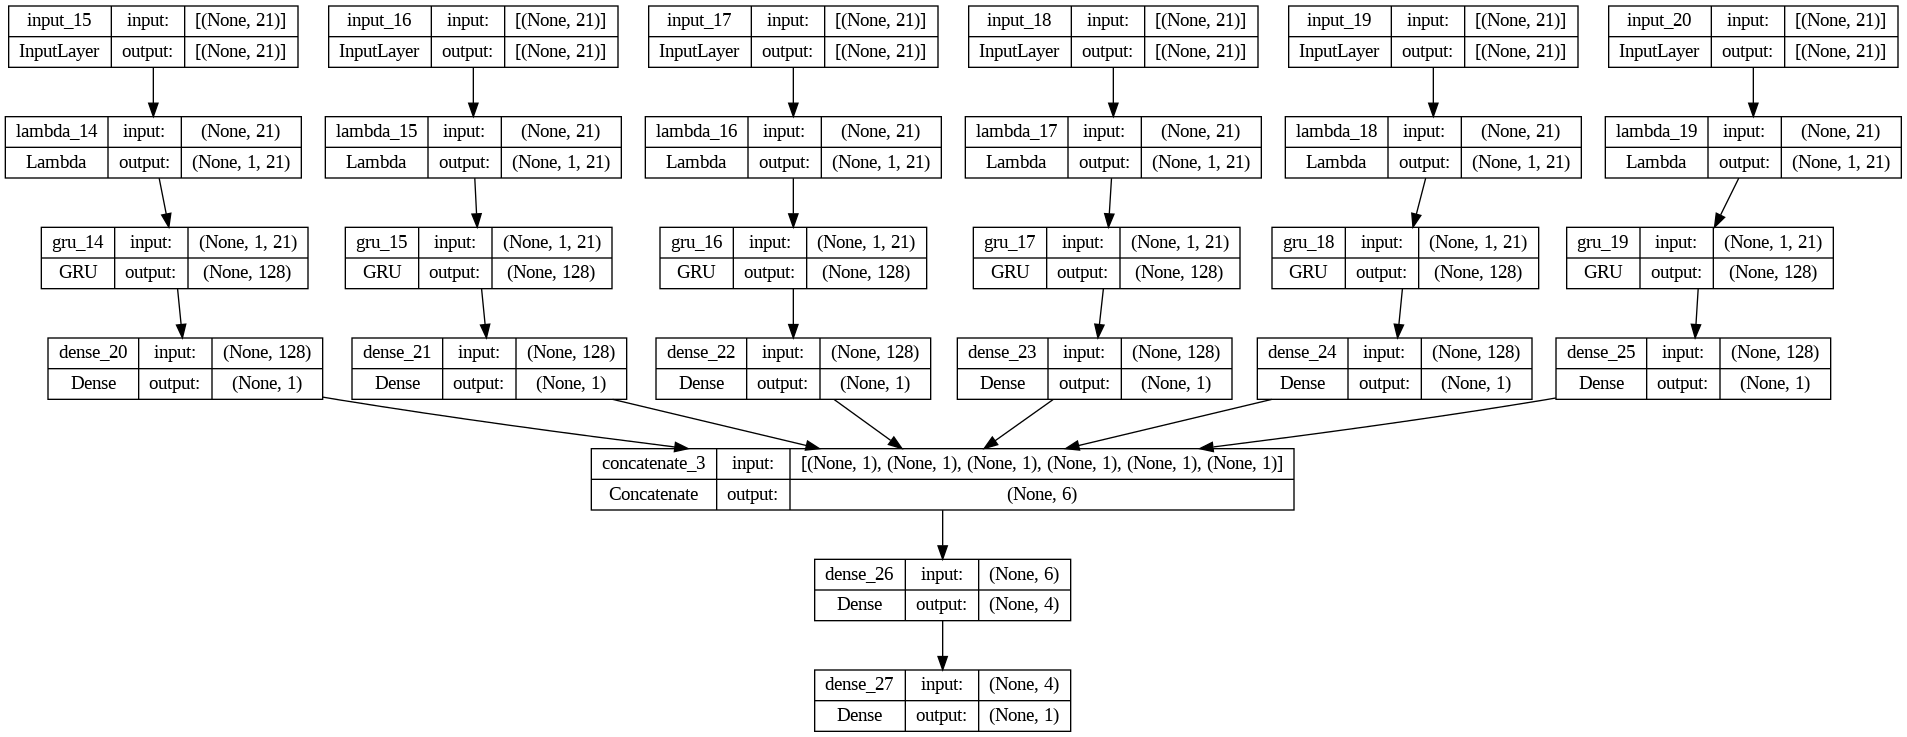

In [118]:
plot_model(proj_wm, show_shapes=True)

In [119]:
# Evaluate on test data
proj_wm.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_wm_test)

32/32 [==============================] - 0s 7ms/step - loss: 40.4715 - mse: 40.4715


[40.471534729003906, 40.471534729003906]

In [172]:
# Use the saved best performing model_1 and evaluate it on test data
proj_wm=tf.keras.models.load_model('/content/model_experiments/proj_wm_multiGRU')
proj_wm.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_wm_test)

32/32 [==============================] - 1s 4ms/step - loss: 22.7927 - mse: 22.7927


[22.79265022277832, 22.79265022277832]

In [121]:
# Save a model in HDF5 format
proj_wm.save("WALMART_MODEL_2A.h5")

In [173]:
# Make predictions
proj_wm_preds = make_preds(proj_wm, [X_wm_test, X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test])

32/32 [==============================] - 3s 6ms/step


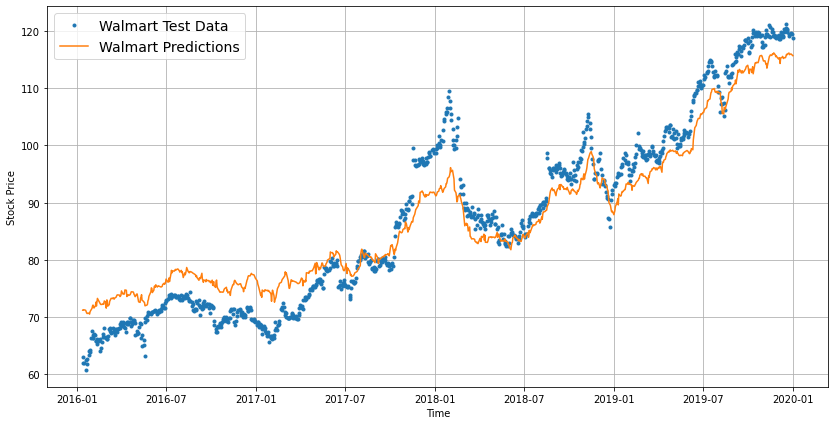

In [174]:
# VISUAL
offset = 0
plt.figure(figsize=(14,7))

plot_time_series(timesteps=y_wm_test.index.to_numpy(),
                 values=y_wm_test,
                 start=offset,
                 label='Walmart Test Data')
plot_time_series(timesteps=y_wm_test.index.to_numpy(),
                 values=proj_wm_preds,
                 start=offset,
                 format='-',
                 label='Walmart Predictions')

In [124]:
# Evaluate preds
proj_wm_results = evaluate_preds(y_true=y_wm_test,
                                 y_pred=proj_wm_preds)
proj_wm_results

{'mae': 4.171005,
 'mse': 22.792656,
 'rmse': 4.774165,
 'mape': 4.9881535,
 'mase': 6.0861206}

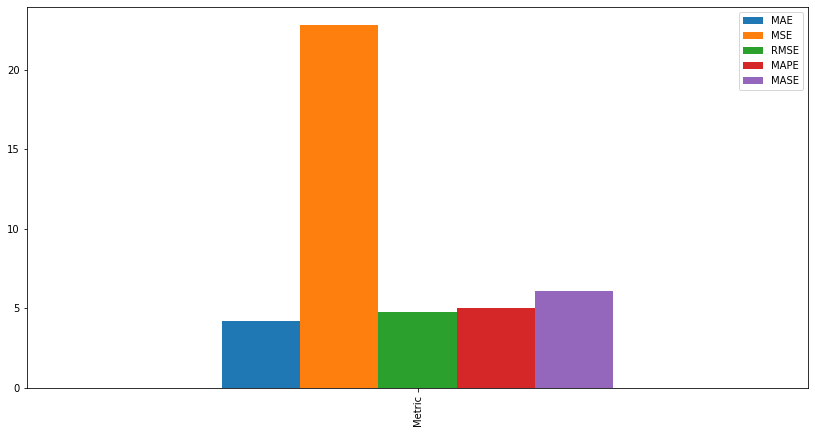

In [125]:
# VISUAL of metrics
pd.DataFrame({'MAE': proj_wm_results['mae'],
              'MSE': proj_wm_results['mse'],
              'RMSE': proj_wm_results['rmse'],
              'MAPE': proj_wm_results['mape'],
              'MASE': proj_wm_results['mase'],
              },index=['Metric']).plot(figsize=(14,7),kind='bar')

### Project Model 200: COSTCO

In [126]:
proj_costco = tf.keras.Model(inputs=[input1,input2,input3,input4,input5,input6],
                         outputs=output, 
                         name='proj_costco_multiGRU')

# Compile
proj_costco.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=['mse'])

# Fit
proj_costco.fit(x=[X_wm_train,X_costco_train,X_KO_train,X_NSRGY_train,X_PEP_train,X_PG_train],
            y=y_costco_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_costco_test),
            callbacks=[create_model_checkpoint(model_name=proj_costco.name)])

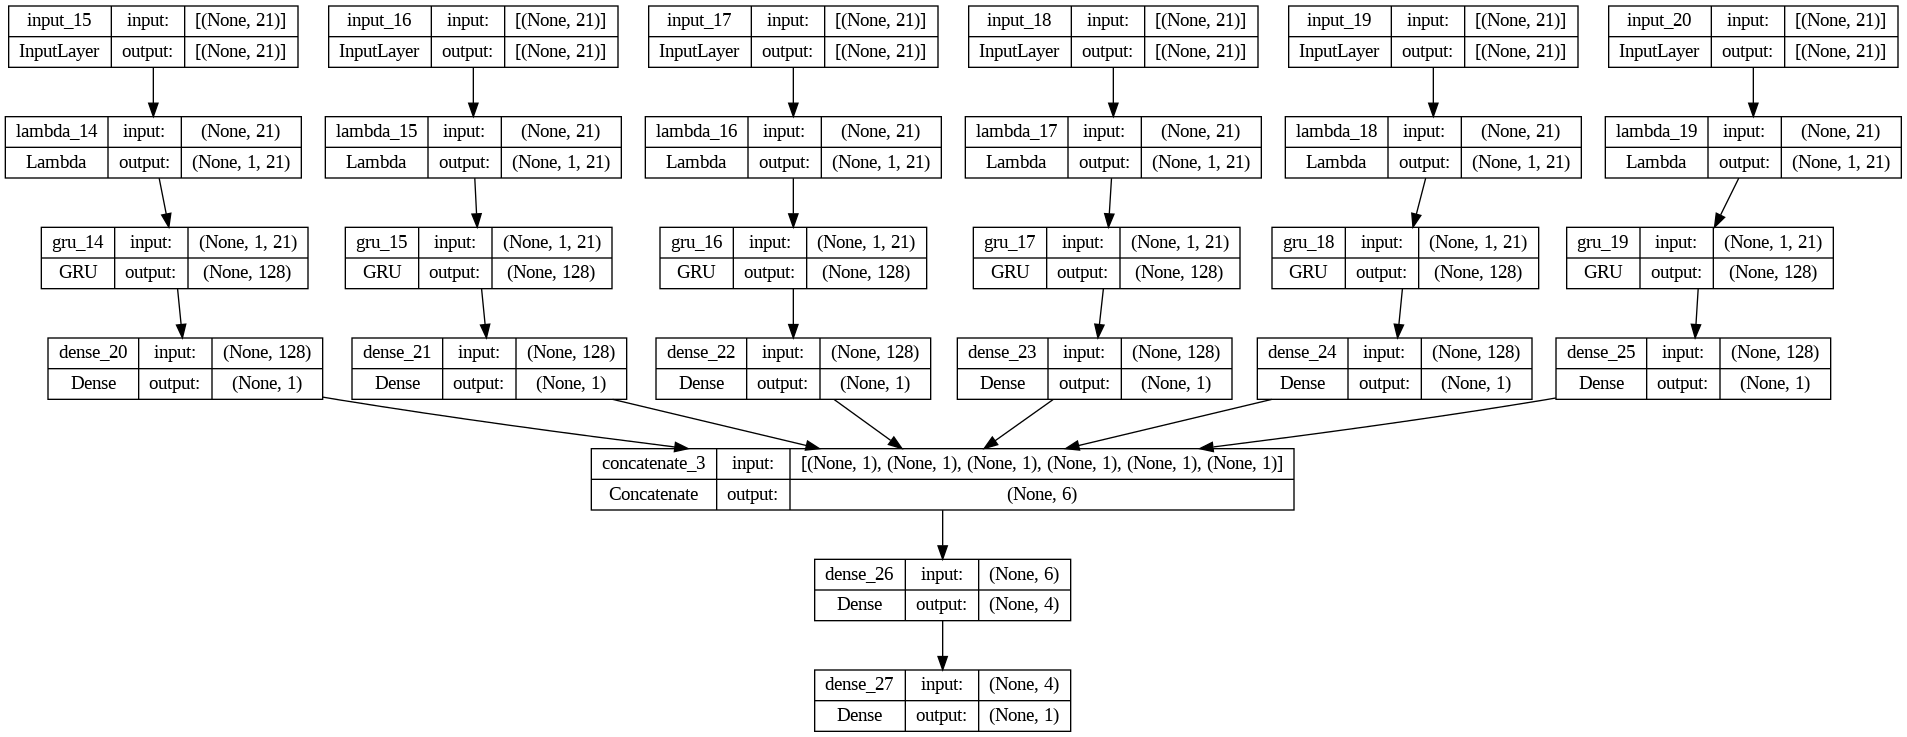

In [127]:
plot_model(proj_costco, show_shapes=True)

In [128]:
# Evaluate on test data
proj_costco.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_costco_test)

32/32 [==============================] - 0s 4ms/step - loss: 43.3561 - mse: 43.3561


[43.35611343383789, 43.35611343383789]

In [175]:
# Use the saved best performing model_1 and evaluate it on test data
proj_costco=tf.keras.models.load_model('/content/model_experiments/proj_costco_multiGRU')
proj_costco.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_costco_test)

32/32 [==============================] - 1s 5ms/step - loss: 43.3561 - mse: 43.3561


[43.35611343383789, 43.35611343383789]

In [130]:
# Save a model in HDF5 format
proj_costco.save("COSTCO_MODEL_2A.h5")

In [131]:
# Make predictions
proj_costco_preds = make_preds(proj_costco, [X_wm_test, X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test])

32/32 [==============================] - 1s 4ms/step


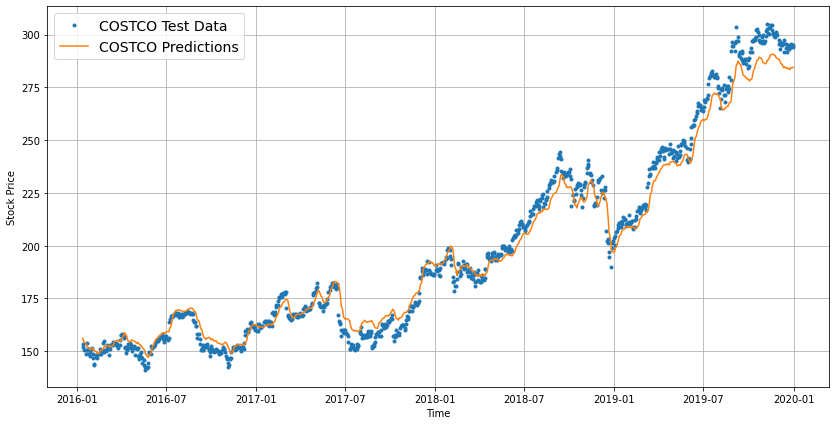

In [176]:
# VISUAL
offset = 0
plt.figure(figsize=(14,7))

plot_time_series(timesteps=y_costco_test.index.to_numpy(),
                 values=y_costco_test,
                 start=offset,
                 label='COSTCO Test Data')
plot_time_series(timesteps=y_costco_test.index.to_numpy(),
                 values=proj_costco_preds,
                 start=offset,
                 format='-',
                 label='COSTCO Predictions')

In [133]:
# Evaluate preds
proj_costco_results = evaluate_preds(y_true=y_costco_test,
                                 y_pred=proj_costco_preds)
proj_costco_results

{'mae': 5.2323065,
 'mse': 43.356117,
 'rmse': 6.584536,
 'mape': 2.5457318,
 'mase': 3.2136786}

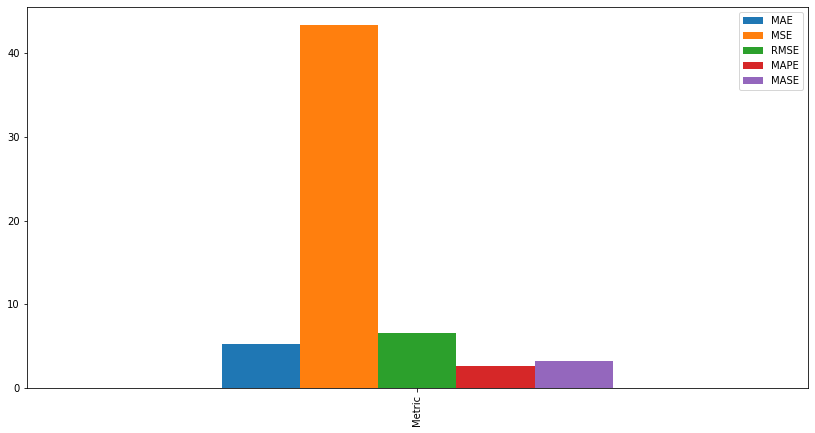

In [134]:
# VISUAL of metrics
pd.DataFrame({'MAE': proj_costco_results['mae'],
              'MSE': proj_costco_results['mse'],
              'RMSE': proj_costco_results['rmse'],
              'MAPE': proj_costco_results['mape'],
              'MASE': proj_costco_results['mase'],
              },index=['Metric']).plot(figsize=(14,7),kind='bar')

### Project Model 300: KO

In [135]:
proj_KO = tf.keras.Model(inputs=[input1,input2,input3,input4,input5,input6],
                         outputs=output, 
                         name='proj_KO_multiGRU')

# Compile
proj_KO.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=['mse'])

# Fit
proj_KO.fit(x=[X_wm_train,X_costco_train,X_KO_train,X_NSRGY_train,X_PEP_train,X_PG_train],
            y=y_KO_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_KO_test),
            callbacks=[create_model_checkpoint(model_name=proj_KO.name)])

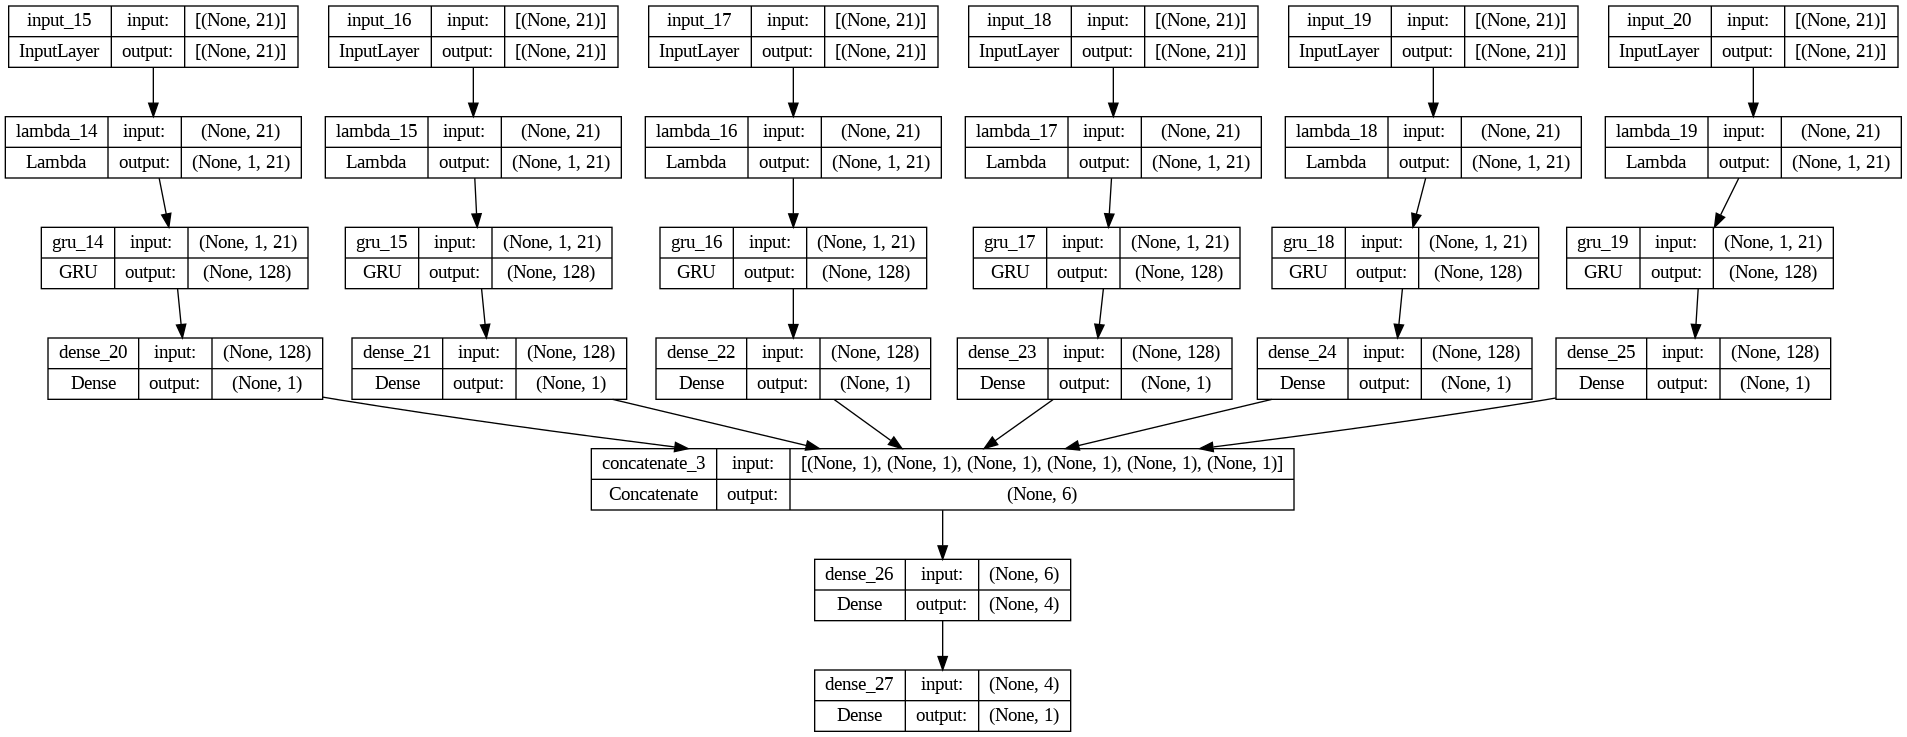

In [136]:
plot_model(proj_KO, show_shapes=True)

In [137]:
# Evaluate on test data
proj_KO.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_KO_test)

32/32 [==============================] - 0s 5ms/step - loss: 145.5207 - mse: 145.5207


[145.5207061767578, 145.5207061767578]

In [177]:
# Use the saved best performing model_1 and evaluate it on test data
proj_KO=tf.keras.models.load_model('/content/model_experiments/proj_KO_multiGRU')
proj_KO.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_KO_test)

32/32 [==============================] - 1s 5ms/step - loss: 25.2452 - mse: 25.2452


[25.24518394470215, 25.24518394470215]

In [140]:
# Save a model in HDF5 format
proj_KO.save("KO_MODEL_2A.h5")

In [178]:
# Make predictions
proj_KO_preds = make_preds(proj_KO, [X_wm_test, X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test])

32/32 [==============================] - 1s 4ms/step


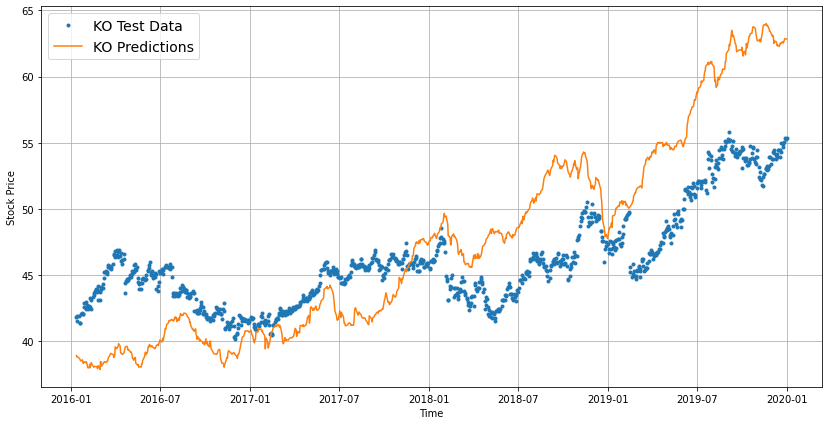

In [179]:
# VISUAL
offset = 0
plt.figure(figsize=(14,7))

plot_time_series(timesteps=y_KO_test.index.to_numpy(),
                 values=y_KO_test,
                 start=offset,
                 label='KO Test Data')
plot_time_series(timesteps=y_KO_test.index.to_numpy(),
                 values=proj_KO_preds,
                 start=offset,
                 format='-',
                 label='KO Predictions')

In [143]:
# Evaluate preds
proj_KO_results = evaluate_preds(y_true=y_KO_test,
                                 y_pred=proj_KO_preds)
proj_KO_results

{'mae': 4.3343525,
 'mse': 25.245186,
 'rmse': 5.024459,
 'mape': 9.214815,
 'mase': 14.811955}

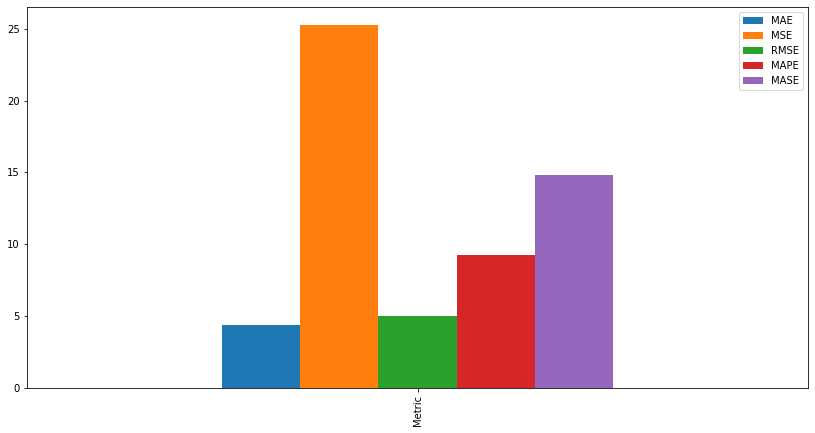

In [144]:
# VISUAL of metrics
pd.DataFrame({'MAE': proj_KO_results['mae'],
              'MSE': proj_KO_results['mse'],
              'RMSE': proj_KO_results['rmse'],
              'MAPE': proj_KO_results['mape'],
              'MASE': proj_KO_results['mase'],
              },index=['Metric']).plot(figsize=(14,7),kind='bar')

### Project Model 400: NSRGY

In [145]:
proj_NSRGY = tf.keras.Model(inputs=[input1,input2,input3,input4,input5,input6],
                         outputs=output, 
                         name='proj_NSRGY_multiGRU')

# Compile
proj_NSRGY.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=['mse'])

# Fit
proj_NSRGY.fit(x=[X_wm_train,X_costco_train,X_KO_train,X_NSRGY_train,X_PEP_train,X_PG_train],
            y=y_NSRGY_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_NSRGY_test),
            callbacks=[create_model_checkpoint(model_name=proj_NSRGY.name)])

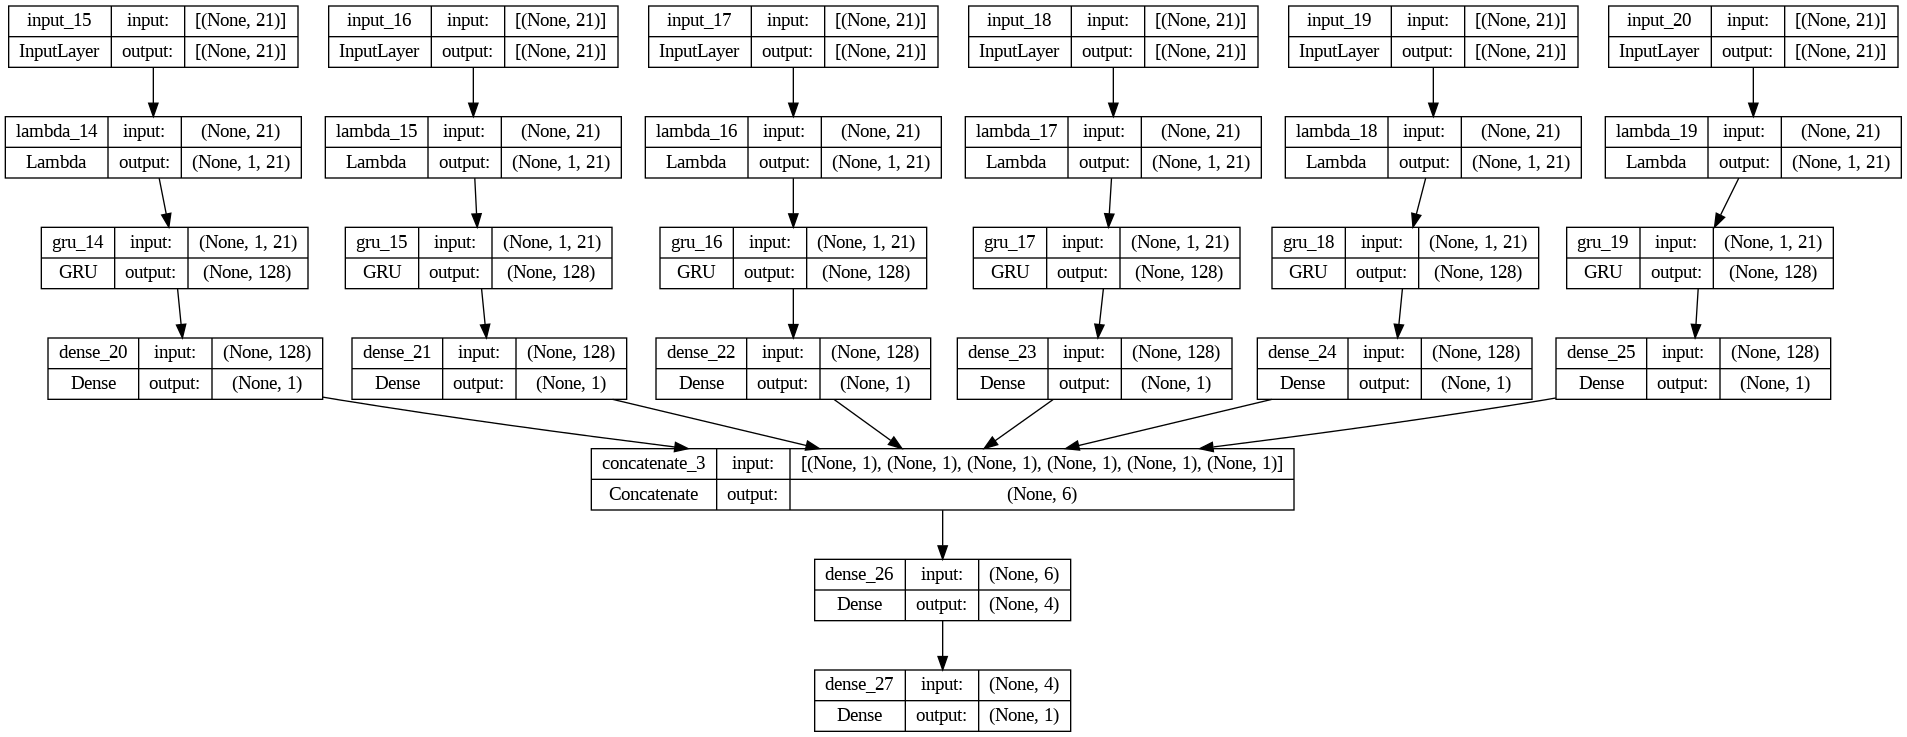

In [146]:
plot_model(proj_NSRGY, show_shapes=True)

In [147]:
# Evaluate on test data
proj_NSRGY.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_NSRGY_test)

32/32 [==============================] - 0s 5ms/step - loss: 18.3419 - mse: 18.3419


[18.341899871826172, 18.341899871826172]

In [180]:
# Use the saved best performing model_1 and evaluate it on test data
proj_NSRGY=tf.keras.models.load_model('/content/model_experiments/proj_NSRGY_multiGRU')
proj_NSRGY.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_NSRGY_test)

32/32 [==============================] - 1s 5ms/step - loss: 9.1921 - mse: 9.1921


[9.192118644714355, 9.192118644714355]

In [149]:
# Save a model in HDF5 format
proj_NSRGY.save("NSRGY_MODEL_2A.h5")

In [181]:
# Make predictions
proj_NSRGY_preds = make_preds(proj_NSRGY, [X_wm_test, X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test])

32/32 [==============================] - 1s 4ms/step


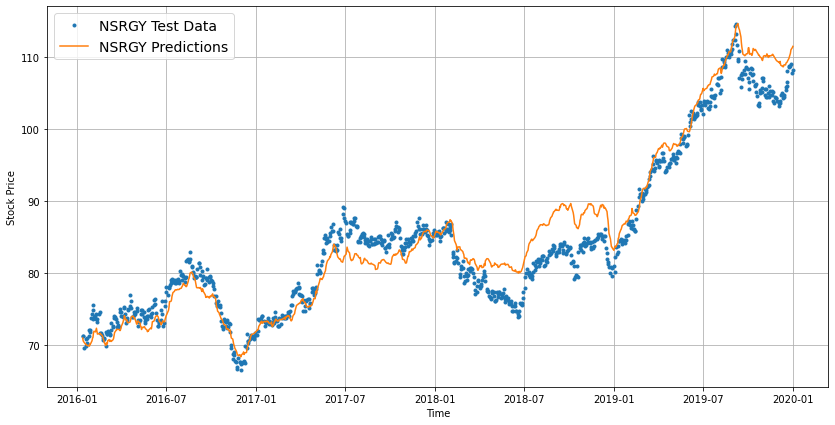

In [182]:
# VISUAL
offset = 0
plt.figure(figsize=(14,7))

plot_time_series(timesteps=y_NSRGY_test.index.to_numpy(),
                 values=y_NSRGY_test,
                 start=offset,
                 label='NSRGY Test Data')
plot_time_series(timesteps=y_NSRGY_test.index.to_numpy(),
                 values=proj_NSRGY_preds,
                 start=offset,
                 format='-',
                 label='NSRGY Predictions')

In [152]:
# Evaluate preds
proj_NSRGY_results = evaluate_preds(y_true=y_NSRGY_test,
                                 y_pred=proj_NSRGY_preds)
proj_NSRGY_results

{'mae': 2.4462726,
 'mse': 9.192119,
 'rmse': 3.0318506,
 'mape': 2.8955662,
 'mase': 4.14989}

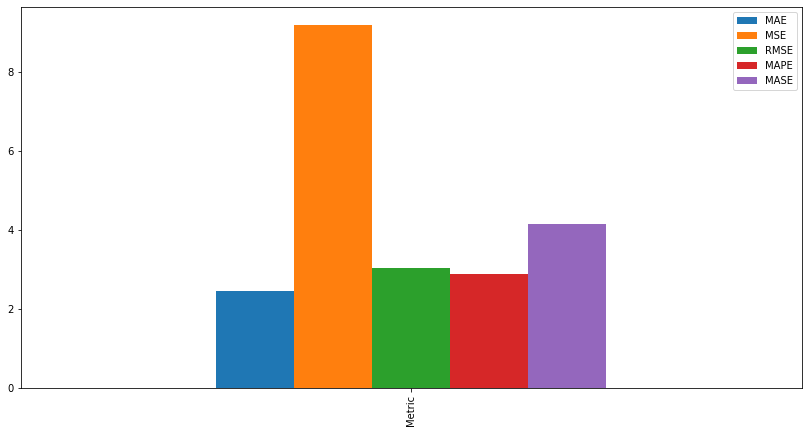

In [153]:
# VISUAL of metrics
pd.DataFrame({'MAE': proj_NSRGY_results['mae'],
              'MSE': proj_NSRGY_results['mse'],
              'RMSE': proj_NSRGY_results['rmse'],
              'MAPE': proj_NSRGY_results['mape'],
              'MASE': proj_NSRGY_results['mase'],
              },index=['Metric']).plot(figsize=(14,7),kind='bar')

### Project Model 500: PEP

In [154]:
proj_PEP = tf.keras.Model(inputs=[input1,input2,input3,input4,input5,input6],
                         outputs=output, 
                         name='proj_PEP_multiGRU')

# Compile
proj_PEP.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=['mse'])

# Fit
proj_PEP.fit(x=[X_wm_train,X_costco_train,X_KO_train,X_NSRGY_train,X_PEP_train,X_PG_train],
            y=y_PEP_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_PEP_test),
            callbacks=[create_model_checkpoint(model_name=proj_PEP.name)])

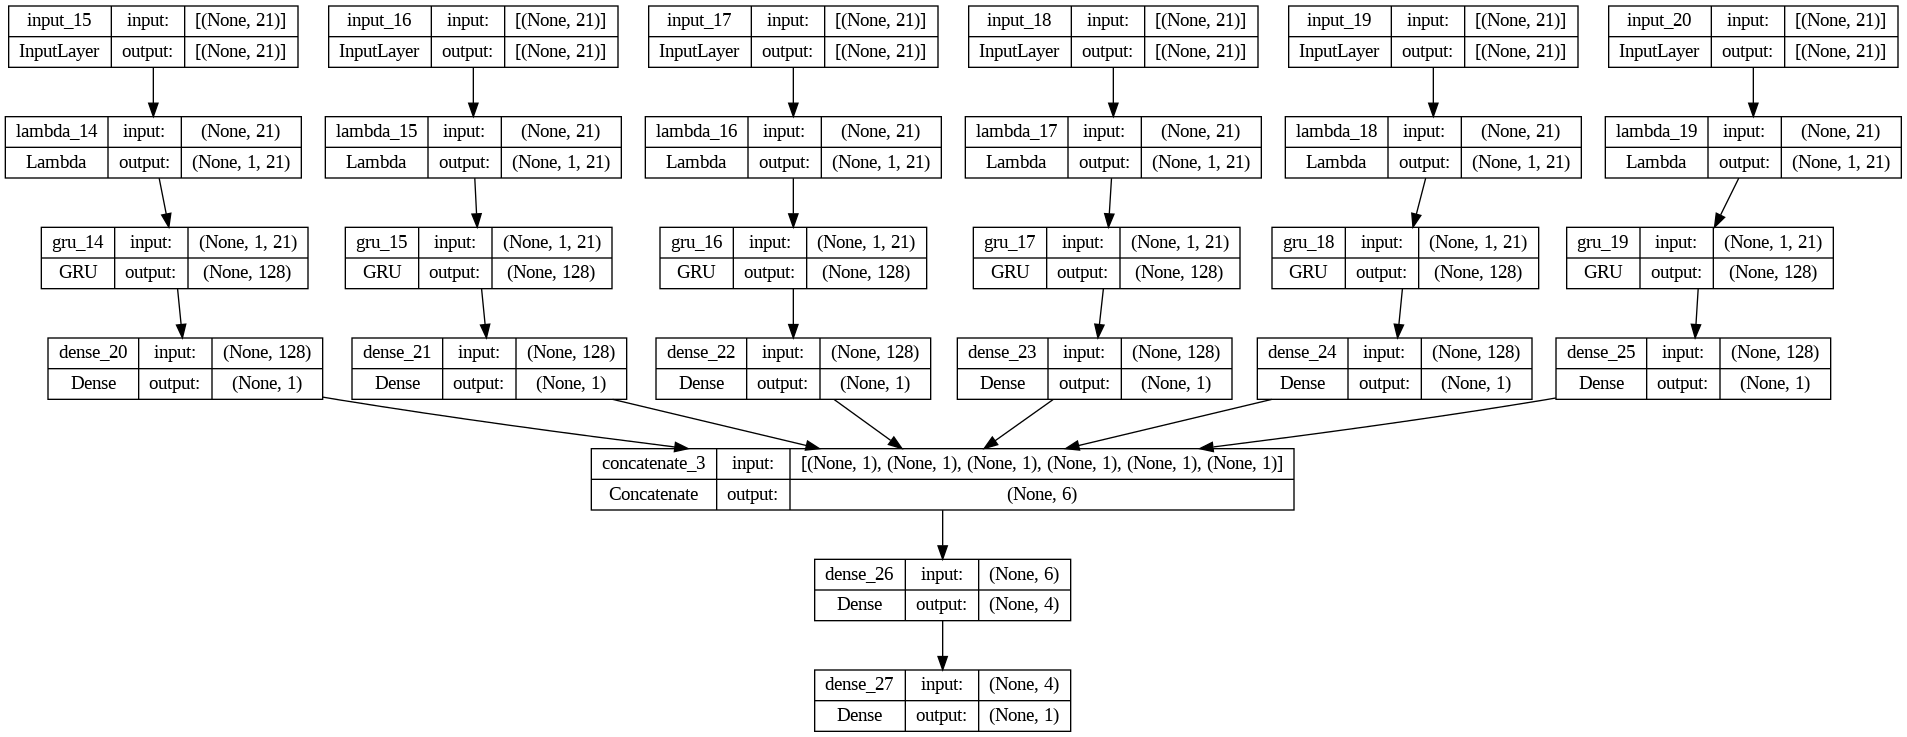

In [157]:
plot_model(proj_PEP, show_shapes=True)

In [155]:
# Evaluate on test data
proj_PEP.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_PEP_test)

32/32 [==============================] - 0s 7ms/step - loss: 16.6398 - mse: 16.6398


[16.639814376831055, 16.639814376831055]

In [183]:
# Use the saved best performing model_1 and evaluate it on test data
proj_PEP=tf.keras.models.load_model('/content/model_experiments/proj_PEP_multiGRU')
proj_PEP.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_PEP_test)

32/32 [==============================] - 2s 5ms/step - loss: 5.6156 - mse: 5.6156


[5.615561485290527, 5.615561485290527]

In [158]:
# Save a model in HDF5 format
proj_PEP.save("PEP_MODEL_2A.h5")

In [159]:
# Make predictions
proj_PEP_preds = make_preds(proj_PEP, [X_wm_test, X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test])

32/32 [==============================] - 1s 4ms/step


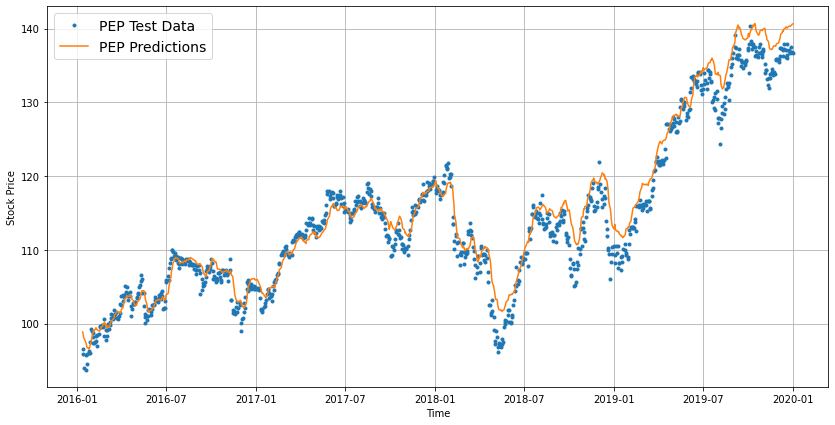

In [184]:
# VISUAL
offset = 0
plt.figure(figsize=(14,7))

plot_time_series(timesteps=y_PEP_test.index.to_numpy(),
                 values=y_PEP_test,
                 start=offset,
                 label='PEP Test Data')
plot_time_series(timesteps=y_PEP_test.index.to_numpy(),
                 values=proj_PEP_preds,
                 start=offset,
                 format='-',
                 label='PEP Predictions')

In [161]:
# Evaluate preds
proj_PEP_results = evaluate_preds(y_true=y_PEP_test,
                                 y_pred=proj_PEP_preds)
proj_PEP_results

{'mae': 1.8020772,
 'mse': 5.615562,
 'rmse': 2.3697178,
 'mape': 1.5781025,
 'mase': 2.4230022}

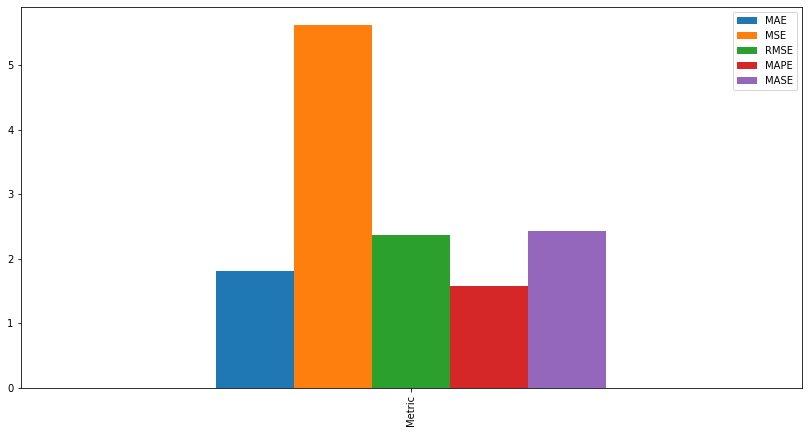

In [162]:
# VISUAL of metrics
pd.DataFrame({'MAE': proj_PEP_results['mae'],
              'MSE': proj_PEP_results['mse'],
              'RMSE': proj_PEP_results['rmse'],
              'MAPE': proj_PEP_results['mape'],
              'MASE': proj_PEP_results['mase'],
              },index=['Metric']).plot(figsize=(14,7),kind='bar')

### Project Model 600: PG

In [163]:
proj_PG = tf.keras.Model(inputs=[input1,input2,input3,input4,input5,input6],
                         outputs=output, 
                         name='proj_PG_multiGRU')

# Compile
proj_PG.compile(loss='mse',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=['mse'])

# Fit
proj_PG.fit(x=[X_wm_train,X_costco_train,X_KO_train,X_NSRGY_train,X_PEP_train,X_PG_train],
            y=y_PG_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_PG_test),
            callbacks=[create_model_checkpoint(model_name=proj_PG.name)])

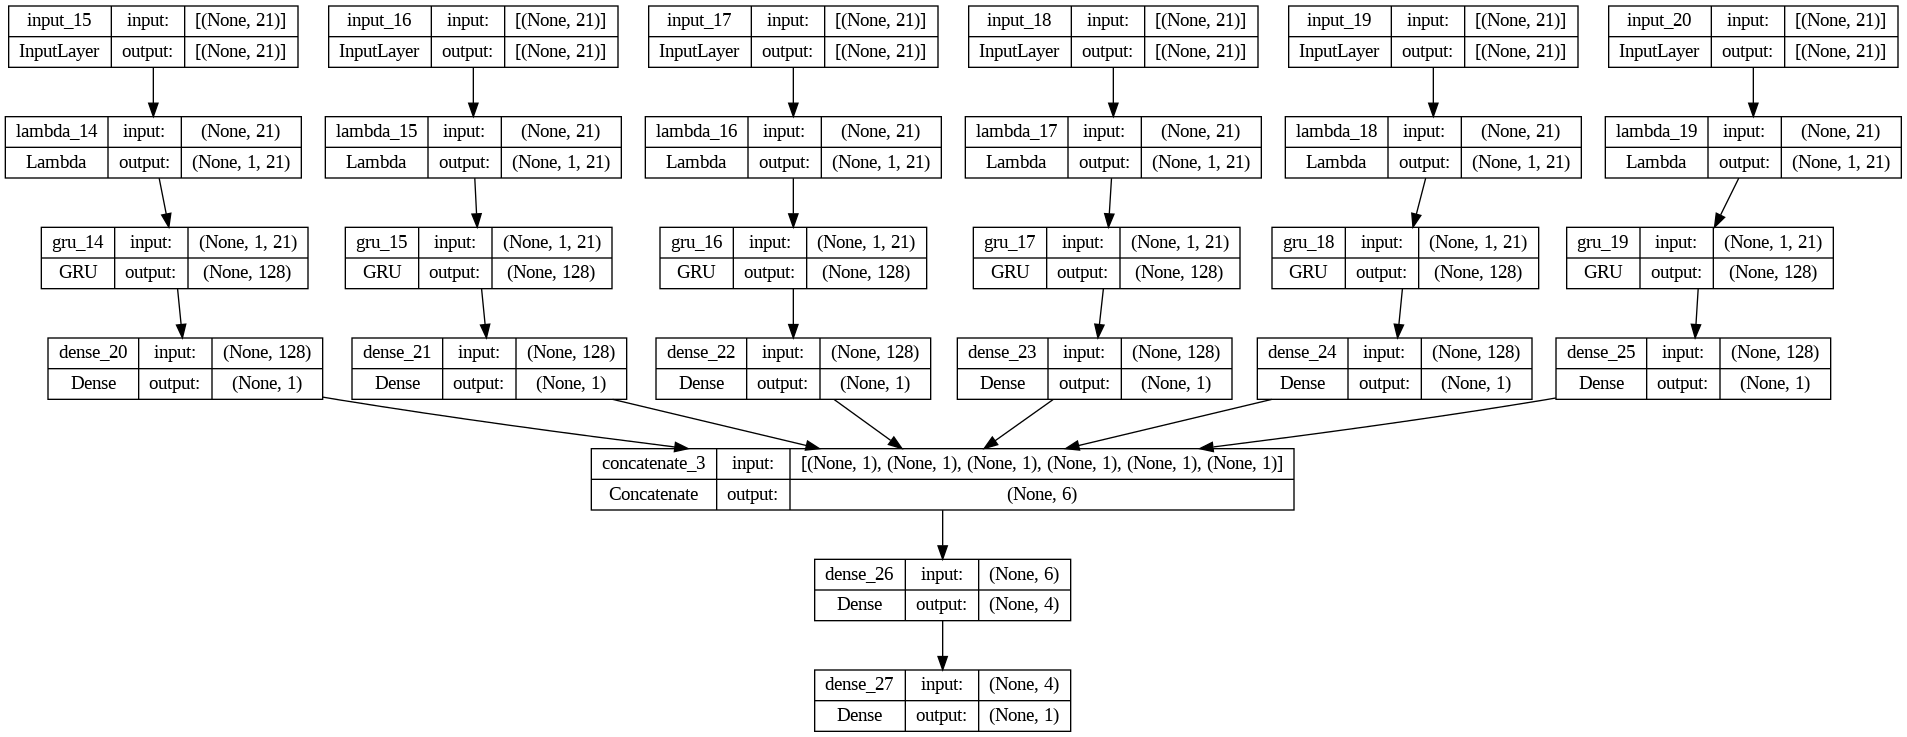

In [164]:
plot_model(proj_PEP, show_shapes=True)

In [165]:
# Evaluate on test data
proj_PG.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_PG_test)

32/32 [==============================] - 0s 6ms/step - loss: 46.3526 - mse: 46.3526


[46.352596282958984, 46.352596282958984]

In [166]:
# Use the saved best performing model_1 and evaluate it on test data
proj_PG=tf.keras.models.load_model('/content/model_experiments/proj_PG_multiGRU')
proj_PG.evaluate([X_wm_test,X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test], y_PG_test)

32/32 [==============================] - 1s 5ms/step - loss: 17.7197 - mse: 17.7197


[17.719749450683594, 17.719749450683594]

In [167]:
# Save a model in HDF5 format
proj_PG.save("PG_MODEL_2A.h5")

In [168]:
# Make predictions
proj_PG_preds = make_preds(proj_PG, [X_wm_test, X_costco_test,X_KO_test,X_NSRGY_test,X_PEP_test,X_PG_test])

32/32 [==============================] - 1s 4ms/step


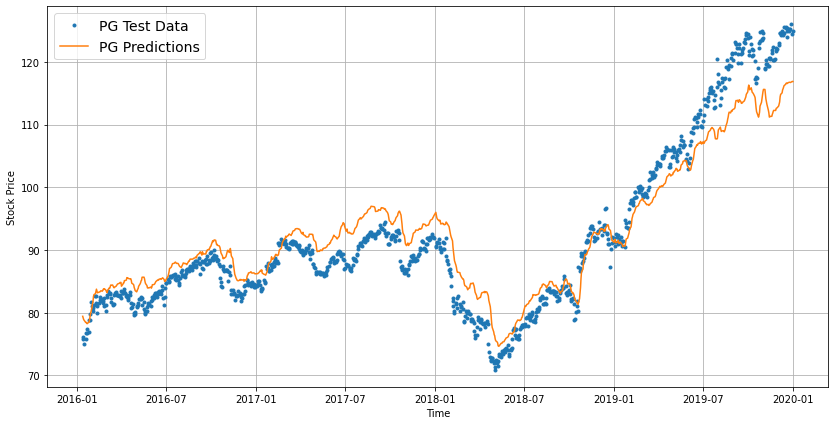

In [169]:
# VISUAL
offset = 0
plt.figure(figsize=(14,7))

plot_time_series(timesteps=y_PG_test.index.to_numpy(),
                 values=y_PG_test,
                 start=offset,
                 label='PG Test Data')
plot_time_series(timesteps=y_PG_test.index.to_numpy(),
                 values=proj_PG_preds,
                 start=offset,
                 format='-',
                 label='PG Predictions')

In [170]:
# Evaluate preds
proj_PG_results = evaluate_preds(y_true=y_PG_test,
                                 y_pred=proj_PG_preds)
proj_PG_results

{'mae': 3.4605818,
 'mse': 17.71975,
 'rmse': 4.209483,
 'mape': 3.6594028,
 'mase': 5.397948}

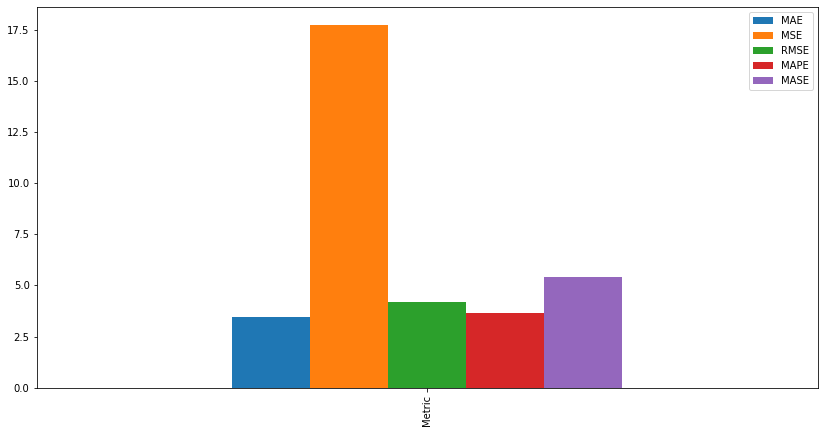

In [171]:
# VISUAL of metrics
pd.DataFrame({'MAE': proj_PG_results['mae'],
              'MSE': proj_PG_results['mse'],
              'RMSE': proj_PG_results['rmse'],
              'MAPE': proj_PG_results['mape'],
              'MASE': proj_PG_results['mase'],
              },index=['Metric']).plot(figsize=(14,7),kind='bar')